# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

### Universidad Nacional de Córdoba
---

In [3]:
import warnings
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from pandas.plotting import lag_plot

import pyarrow
import fastparquet

import statsmodels

In [4]:
df = pd.read_parquet('df_preprocesado.parquet')
df

,dni_titular_movimiento,anio_mes_cupon,antig_cliente,monto_ajustado,comercio_cat=0,comercio_cat=1,comercio_cat=2,comercio_cat=3,comercio_cat=4,comercio_cat=5,...,producto_naranja_movimiento=PL,producto_naranja_movimiento=PN,producto_naranja_movimiento=PP,producto_naranja_movimiento=TA,producto_naranja_movimiento=VI,producto_naranja_movimiento=ZE,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=3,tipo_producto_tarjeta_movimiento=4,fg_aumentado
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008,225,-325.68,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009,226,-318.09,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010,227,-307.74,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011,228,-299.46,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012,229,-290.49,69.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7509,000f0b73ebfa002a79a0642b82e87919904,202101,21,801535.05,207.0,69.0,69.0,0.0,0.0,69.0,...,345.0,0.0,0.0,0.0,0.0,69.0,138.0,276.0,0.0,1
7510,000f0b73ebfa002a79a0642b82e87919904,202102,22,867100.92,207.0,69.0,0.0,0.0,0.0,0.0,...,207.0,0.0,0.0,0.0,0.0,69.0,138.0,138.0,0.0,0
7511,000f0b73ebfa002a79a0642b82e87919904,202103,23,183752.52,138.0,207.0,0.0,0.0,0.0,0.0,...,345.0,0.0,0.0,0.0,0.0,0.0,138.0,207.0,0.0,0
7512,000f0b73ebfa002a79a0642b82e87919904,202104,24,323309.16,276.0,0.0,138.0,0.0,0.0,0.0,...,345.0,0.0,0.0,0.0,0.0,69.0,138.0,276.0,0.0,1


In [5]:
df['monto_ajustado'].describe().round(2)

count       7514.00
mean      807589.43
std      1025642.13
min      -977066.91
25%        65113.61
50%       427092.40
75%      1177538.20
max      9249133.98
Name: monto_ajustado, dtype: float64

In [6]:
df_sin_docu = df.copy()
df_sin_docu.drop(columns=['dni_titular_movimiento','monto_ajustado'], inplace=True)
df_sin_docu['monto_ajustado'] = df['monto_ajustado']

In [7]:
col_x = df_sin_docu.iloc[:,:-1].columns.values
col_x

array(['anio_mes_cupon', 'antig_cliente', 'comercio_cat=0',
       'comercio_cat=1', 'comercio_cat=2', 'comercio_cat=3',
       'comercio_cat=4', 'comercio_cat=5', 'comercio_cat=6',
       'comercio_cat=7', 'comercio_cat=8', 'comercio_cat=9',
       'producto_naranja_movimiento=AX', 'producto_naranja_movimiento=EX',
       'producto_naranja_movimiento=MC', 'producto_naranja_movimiento=PC',
       'producto_naranja_movimiento=PL', 'producto_naranja_movimiento=PN',
       'producto_naranja_movimiento=PP', 'producto_naranja_movimiento=TA',
       'producto_naranja_movimiento=VI', 'producto_naranja_movimiento=ZE',
       'tipo_producto_tarjeta_movimiento=0',
       'tipo_producto_tarjeta_movimiento=3',
       'tipo_producto_tarjeta_movimiento=4', 'fg_aumentado'], dtype=object)

### ScatterPlot de Features y Target

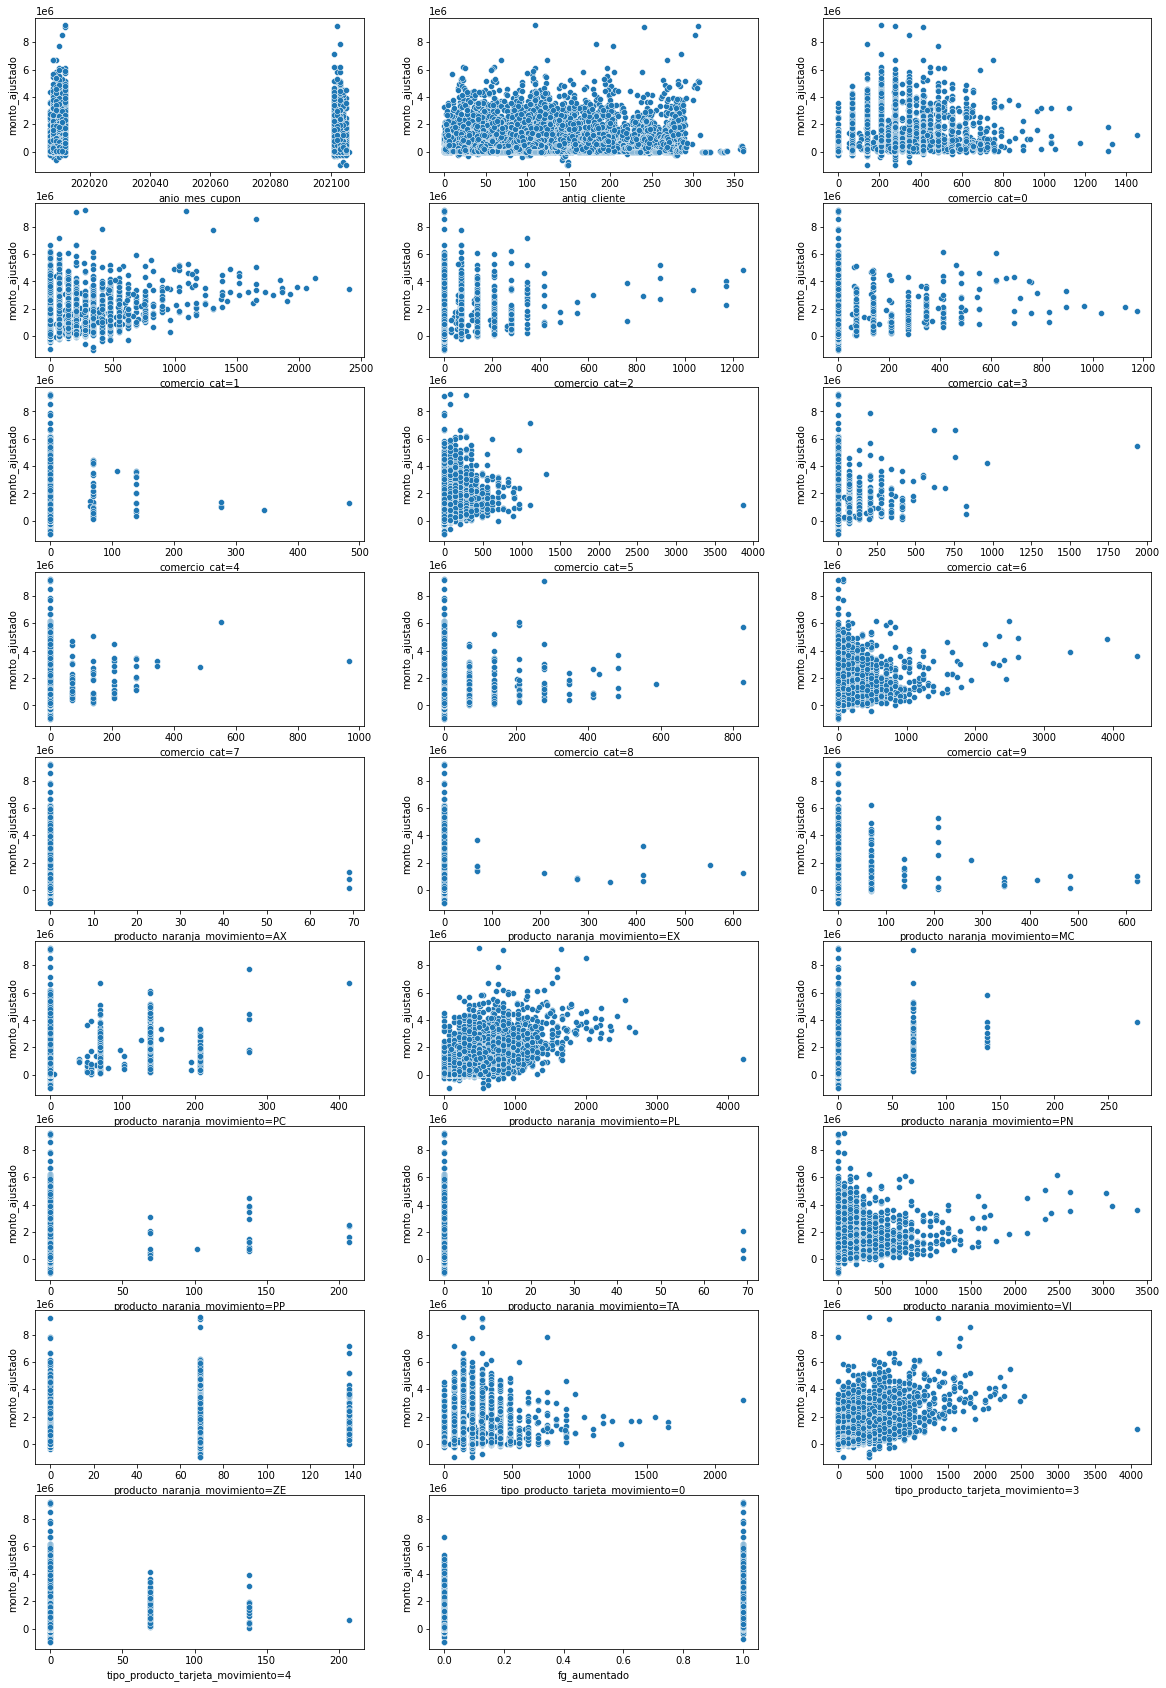

In [8]:
n_cols = 3
n_rows = math.ceil(len(col_x)/3)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 30))
count = 0
for i in col_x:    
    # Calculamos filas y columnas
    row = math.floor(count / n_cols)
    col = count % n_cols
    # Configuramos visualización
    ax = axs[row, col]
    # Visualizamos la distribución de variable
    sns.scatterplot(data=df_sin_docu, x=i, y='monto_ajustado', ax=ax)
    count =count +1

axs[n_rows-1,n_cols-1].axis('off')
plt.show()

### División

En primer lugar, separamos nuestros feautures de los variables target para regresión y clasificación. La división entre train y validation se realizará previo a instanciar cada modelo, debido a que cada uno de ellos requiere un escalado distinto (por ejemplo, un escalado del tipo MaxAbsScaler, utiliza el máximo de todos los features para realizar el preprocesamiento). 

In [7]:
X = df.drop(['dni_titular_movimiento'], axis=1)

X_r = X.drop(['monto_ajustado'], axis=1)
X_c = X.drop(['fg_aumentado', 'monto_ajustado'], axis=1)
y_r = X['monto_ajustado']
y_c = X['fg_aumentado']

X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_r, y_r, test_size=0.3, random_state=0, shuffle=False)
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_c, y_c, test_size=0.3, random_state=0, shuffle=False)

X_train_r = X_train_r.values
X_val_r = X_val_r.values
y_train_r = y_train_r.values.reshape(-1,1)
y_val_r = y_val_r.values.reshape(-1,1)

X_train_c = X_train_c.values
X_val_c = X_val_c.values
y_train_c = y_train_c.values
y_val_c = y_val_c.values

## 3. Regresión

Una vez finalizada la etapa de preprocesamiento, se propone implementar diferentes modelos 
de predicción para el `monto_compra_movimiento`, utilizando la librería Scikit-Learn:

* LinearSVR ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR))
* SGDRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor))
* KNeighborsRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor))
* GaussianProcessRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor))
* VotingRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor))

Y de la libreria XGBoost
* XGBRegressor ([Doc](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor))

De estos tipos de modelos, cuál creen que es el más adecuado para nuestro caso de aplicación?

Utilizar el método Grid Search, o de búsqueda exahustiva, con cross-validation para profundizar en la búsqueda y selección de hiperparámetros.

Calcular métricas sobre el conjunto de entrenamiento y de evaluación para los mejores parámetros obtenidos:
* MSE 
* MAE 
* RMSE

Comparar las métricas obtenidas en cada modelo y obtener conclusiones.

> Una vez encontrado el mejor modelo se validara usando el conjunto de evaluacion dado por el mentor

### Linear SVR - Default

In [8]:
from sklearn.svm import LinearSVR

In [9]:
# división train y test
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_r, y_r, test_size=0.3, random_state=0, shuffle=False)

In [10]:
# escalado de feauteres y target
x_scaler = MinMaxScaler() #MaxAbsScaler()
y_scaler = MinMaxScaler() #MaxAbsScaler()
X_train_r = x_scaler.fit_transform(X_train_r)
X_val_r = x_scaler.fit_transform(X_val_r)
y_train_r = y_scaler.fit_transform(y_train_r.values.reshape(-1, 1))
y_val_r = y_scaler.fit_transform(y_val_r.values.reshape(-1, 1))

In [11]:
#standar= StandardScaler()
#standar.fit_transform(X_r[['anio_mes_cupon']].values.reshape(-1, 1))

In [12]:
X_r.head(10)

,anio_mes_cupon,antig_cliente,comercio_cat=0,comercio_cat=1,comercio_cat=2,comercio_cat=3,comercio_cat=4,comercio_cat=5,comercio_cat=6,comercio_cat=7,...,producto_naranja_movimiento=PL,producto_naranja_movimiento=PN,producto_naranja_movimiento=PP,producto_naranja_movimiento=TA,producto_naranja_movimiento=VI,producto_naranja_movimiento=ZE,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=3,tipo_producto_tarjeta_movimiento=4,fg_aumentado
0,202008,225,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
1,202009,226,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
2,202010,227,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
3,202011,228,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
4,202012,229,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
5,202101,230,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
6,202102,231,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
7,202103,232,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
8,202104,233,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0
9,202105,234,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0


In [13]:
pd.DataFrame(X_train_r, columns=X_r.columns.values).head(10)

,anio_mes_cupon,antig_cliente,comercio_cat=0,comercio_cat=1,comercio_cat=2,comercio_cat=3,comercio_cat=4,comercio_cat=5,comercio_cat=6,comercio_cat=7,...,producto_naranja_movimiento=PL,producto_naranja_movimiento=PN,producto_naranja_movimiento=PP,producto_naranja_movimiento=TA,producto_naranja_movimiento=VI,producto_naranja_movimiento=ZE,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=3,tipo_producto_tarjeta_movimiento=4,fg_aumentado
0,0.010101,0.625000,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
1,0.020202,0.627778,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
2,0.030303,0.630556,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
3,0.040404,0.633333,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
4,0.050505,0.636111,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
5,0.949495,0.638889,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
6,0.959596,0.641667,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
7,0.969697,0.644444,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
8,0.979798,0.647222,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0
9,0.989899,0.650000,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016393,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0


In [14]:
# fit
svr = LinearSVR(random_state=0)
svr.fit(X_train_r, y_train_r)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVR(random_state=0)

In [15]:
# Predict
y_train_pred_svr = svr.predict(X_train_r)
y_valid_pred_svr = svr.predict(X_val_r)

In [16]:
# evaluate MSE:
train_error_svr = mean_squared_error(y_train_r, y_train_pred_svr)
val_error_svr = mean_squared_error(y_val_r, y_valid_pred_svr)
print(f'Train error MSE {train_error_svr.round(3)}, Valid error MSE {val_error_svr.round(3)}') 

Train error MSE 0.006, Valid error MSE 0.008


In [17]:
# evaluate MAE:
train_error_svr = mean_absolute_error(y_train_r, y_train_pred_svr)
val_error_svr = mean_absolute_error(y_val_r, y_valid_pred_svr)
print(f'Train error MAE {train_error_svr.round(3)}, Valid error MAE {val_error_svr.round(3)}') 

Train error MAE 0.042, Valid error MAE 0.063


In [18]:
# evaluate RMSE:
train_error_svr = np.sqrt(mean_squared_error(y_train_r, y_train_pred_svr))
val_error_svr = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_svr))
print(f'Train error RMSE {train_error_svr.round(3)}, Valid error RMSE {val_error_svr.round(3)}') 

Train error RMSE 0.074, Valid error RMSE 0.091


Visualizamos nuestra variable target (real y predicción)

In [19]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

,val_real
count,2255.00
mean,797354.70
std,1058933.73
min,-977066.91
25%,59937.88
50%,397312.35
75%,1149325.76
max,9249133.98


In [20]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

,val_pred
count,2255.00
mean,468173.72
std,1067813.27
min,-569085.90
25%,-316449.93
50%,148997.95
75%,886292.37
max,7175212.34


### Linear SVR - Juani - Escalado

In [21]:
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_r, y_r, test_size=0.3, random_state=0)#, shuffle=False)

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [34]:
# escalado de feauteres y target
"""
x_scaler = MinMaxScaler() #MaxAbsScaler()
y_scaler = MinMaxScaler() #MaxAbsScaler()
X_train_r = x_scaler.fit_transform(X_train_r)
X_val_r = x_scaler.fit_transform(X_val_r)
y_train_r = y_scaler.fit_transform(y_train_r.values.reshape(-1, 1))
y_val_r = y_scaler.fit_transform(y_val_r.values.reshape(-1, 1))
"""

regr = make_pipeline(MinMaxScaler(), LinearSVR(random_state=0, tol=1e-5))
regr.fit(X_train_r,y_train_r)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearsvr', LinearSVR(random_state=0, tol=1e-05))])

In [37]:
print("{:.2f} is the accuracy of the SV Regressor".format(regr.score(X_val_r,y_val_r)))

-0.63 is the accuracy of the SV Regressor


### Linear SVR - Juani - vamos por otro lado

In [40]:
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_r, y_r, test_size=0.3, random_state=0)#, shuffle=False)

In [41]:
x_scaler = MinMaxScaler() #MaxAbsScaler()
y_scaler = MinMaxScaler() #MaxAbsScaler()
X_train_r = x_scaler.fit_transform(X_train_r)
y_train_r = y_scaler.fit_transform(y_train_r.values.reshape(-1, 1))

In [42]:
# fit
svr = LinearSVR(random_state=0)
svr.fit(X_train_r, y_train_r)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVR(random_state=0)

In [43]:
# Predict
y_train_pred_svr = svr.predict(X_train_r)
y_valid_pred_svr = svr.predict(X_val_r)

In [44]:
# evaluate MSE:
train_error_svr = mean_squared_error(y_train_r, y_train_pred_svr)
val_error_svr = mean_squared_error(y_val_r, y_valid_pred_svr)
print(f'Train error MSE {train_error_svr.round(3)}, Valid error MSE {val_error_svr.round(3)}') 

Train error MSE 0.005, Valid error MSE 1723092891103.379


In [45]:
# evaluate MAE:
train_error_svr = mean_absolute_error(y_train_r, y_train_pred_svr)
val_error_svr = mean_absolute_error(y_val_r, y_valid_pred_svr)
print(f'Train error MAE {train_error_svr.round(3)}, Valid error MAE {val_error_svr.round(3)}') 

Train error MAE 0.039, Valid error MAE 821541.202


In [46]:
# evaluate RMSE:
train_error_svr = np.sqrt(mean_squared_error(y_train_r, y_train_pred_svr))
val_error_svr = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_svr))
print(f'Train error RMSE {train_error_svr.round(3)}, Valid error RMSE {val_error_svr.round(3)}') 

Train error RMSE 0.071, Valid error RMSE 1312666.329


### Linear SVR - Juani - sacamos features

In [50]:
X_r.columns.values

array(['anio_mes_cupon', 'antig_cliente', 'comercio_cat=0',
       'comercio_cat=1', 'comercio_cat=2', 'comercio_cat=3',
       'comercio_cat=4', 'comercio_cat=5', 'comercio_cat=6',
       'comercio_cat=7', 'comercio_cat=8', 'comercio_cat=9',
       'producto_naranja_movimiento=AX', 'producto_naranja_movimiento=EX',
       'producto_naranja_movimiento=MC', 'producto_naranja_movimiento=PC',
       'producto_naranja_movimiento=PL', 'producto_naranja_movimiento=PN',
       'producto_naranja_movimiento=PP', 'producto_naranja_movimiento=TA',
       'producto_naranja_movimiento=VI', 'producto_naranja_movimiento=ZE',
       'tipo_producto_tarjeta_movimiento=0',
       'tipo_producto_tarjeta_movimiento=3',
       'tipo_producto_tarjeta_movimiento=4', 'fg_aumentado'], dtype=object)

In [51]:
X_svr = X_r[['antig_cliente', 'comercio_cat=0', 'comercio_cat=1', 'comercio_cat=2', 'comercio_cat=3',
             'comercio_cat=9', 'producto_naranja_movimiento=PL', 'producto_naranja_movimiento=VI',
             'tipo_producto_tarjeta_movimiento=0', 'tipo_producto_tarjeta_movimiento=3']]
X_svr.head()

,antig_cliente,comercio_cat=0,comercio_cat=1,comercio_cat=2,comercio_cat=3,comercio_cat=9,producto_naranja_movimiento=PL,producto_naranja_movimiento=VI,tipo_producto_tarjeta_movimiento=0,tipo_producto_tarjeta_movimiento=3
0,225,69.0,0.0,0.0,0.0,0.0,69.0,0.0,69.0,0.0
1,226,69.0,0.0,0.0,0.0,0.0,69.0,0.0,69.0,0.0
2,227,69.0,0.0,0.0,0.0,0.0,69.0,0.0,69.0,0.0
3,228,69.0,0.0,0.0,0.0,0.0,69.0,0.0,69.0,0.0
4,229,69.0,0.0,0.0,0.0,0.0,69.0,0.0,69.0,0.0


In [59]:
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_svr, y_r, test_size=0.3, random_state=0)#, shuffle=False)

In [60]:
x_scaler = MinMaxScaler() #MaxAbsScaler()
y_scaler = MinMaxScaler() #MaxAbsScaler()
X_train_r = x_scaler.fit_transform(X_train_r)
X_val_r = x_scaler.transform(X_val_r)
y_train_r = y_scaler.fit_transform(y_train_r.values.reshape(-1, 1))
y_val_r = y_scaler.transform(y_val_r.values.reshape(-1, 1))

In [61]:
# fit
svr = LinearSVR(random_state=0)
svr.fit(X_train_r, y_train_r)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVR(random_state=0)

In [62]:
# Predict
y_train_pred_svr = svr.predict(X_train_r)
y_valid_pred_svr = svr.predict(X_val_r)

In [63]:
# evaluate MSE:
train_error_svr = mean_squared_error(y_train_r, y_train_pred_svr)
val_error_svr = mean_squared_error(y_val_r, y_valid_pred_svr)
print(f'Train error MSE {train_error_svr.round(3)}, Valid error MSE {val_error_svr.round(3)}') 

Train error MSE 0.006, Valid error MSE 0.006


In [64]:
# evaluate MAE:
train_error_svr = mean_absolute_error(y_train_r, y_train_pred_svr)
val_error_svr = mean_absolute_error(y_val_r, y_valid_pred_svr)
print(f'Train error MAE {train_error_svr.round(3)}, Valid error MAE {val_error_svr.round(3)}') 

Train error MAE 0.043, Valid error MAE 0.044


In [65]:
# evaluate RMSE:
train_error_svr = np.sqrt(mean_squared_error(y_train_r, y_train_pred_svr))
val_error_svr = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_svr))
print(f'Train error RMSE {train_error_svr.round(3)}, Valid error RMSE {val_error_svr.round(3)}') 

Train error RMSE 0.079, Valid error RMSE 0.078


In [71]:
y_scaler.inverse_transform(y_train_pred_svr.reshape(-1,1))

array([[   5153.70923548],
       [1358979.68484747],
       [  19694.15019502],
       ...,
       [ 464208.98217574],
       [ 685507.78335682],
       [ 694379.94694085]])

### Linear SVR - Grid Search

In [40]:
param_grid = {
    'epsilon': [0.1, 0.01, 0.0001,0.001],
    'tol': [1e-3, 1e-4, 1e-5, 1e-6],
    'C': [1, 2, 0.01, 0.001],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

cv_svr = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_svr.fit(X_train_r, y_train_r)

C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=5, estimator=LinearSVR(random_state=0),
             param_grid={'C': [1, 2, 0.01, 0.001],
                         'epsilon': [0.1, 0.01, 0.0001, 0.001],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'tol': [0.001, 0.0001, 1e-05, 1e-06]},
             scoring='neg_mean_squared_error')

In [ ]:
cv_svr.best_params_

In [ ]:
cv_svr.best_estimator_

In [ ]:
# Predict
y_train_pred_svr = cv_svr.best_estimator_.predict(X_train_r)
y_valid_pred_svr = cv_svr.best_estimator_.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_svr = mean_squared_error(y_train_r, y_train_pred_svr)
val_error_svr = mean_squared_error(y_val_r, y_valid_pred_svr)
print(f'Train error {train_error_svr.round(3)}, Valid error {val_error_svr.round(3)}')  

In [ ]:
# evaluate MAE:
train_error_svr = mean_absolute_error(y_train_r, y_train_pred_svr)
val_error_svr = mean_absolute_error(y_val_r, y_valid_pred_svr)
print(f'Train error MAE {train_error_svr.round(3)}, Valid error MAE {val_error_svr.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_svr = np.sqrt(mean_squared_error(y_train_r, y_train_pred_svr))
val_error_svr = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_svr))
print(f'Train error RMSE {train_error_svr.round(3)}, Valid error RMSE {val_error_svr.round(3)}') 

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_svr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### SGDRegressor - Default

In [ ]:
from sklearn.linear_model import SGDRegressor

Utilizamos las variables X_train_r, X_val_r, y_train_r, y_val_r debido a que en este modelo utilizamos el mismo escalado que SVM-R. 

In [ ]:
# Fit
sgd = SGDRegressor(random_state=0, shuffle=False)
sgd.fit(X_train_r, y_train_r)

In [ ]:
# Predict
y_train_pred_sgd = sgd.predict(X_train_r)
y_valid_pred_sgd = sgd.predict(X_val_r)

In [ ]:
# evaluate:
train_error_sgd = mean_squared_error(y_train_r, y_train_pred_sgd)
val_error_sgd = mean_squared_error(y_val_r, y_valid_pred_sgd)
print(f'Train error {train_error_sgd.round(3)}, Valid error {val_error_sgd.round(3)}')  

In [ ]:
# evaluate MAE:
train_error_sgd = mean_absolute_error(y_train_r, y_train_pred_sgd)
val_error_sgd = mean_absolute_error(y_val_r, y_valid_pred_sgd)
print(f'Train error MAE {train_error_sgd.round(3)}, Valid error MAE {val_error_sgd.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_sgd = np.sqrt(mean_squared_error(y_train_r, y_train_pred_sgd))
val_error_sgd = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_sgd))
print(f'Train error RMSE {train_error_sgd.round(3)}, Valid error RMSE {val_error_sgd.round(3)}') 

Visualizamos nuestra variable target (real y predicción)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### SGDRegressor- Grid Search

In [ ]:
param_grid = {
    'loss': ['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'],
    'penalty': ['l2','l1'],
    'alpha': [0.001, 0.01, 0.1, 1],
    'epsilon': [0.1, 0.01],
    'tol': [1e-3, 1e-4],
    'learning_rate': ['optimal', 'constant', 'adaptive','invscaling']
    #'max_iter': [1000, 2000, 5000]
}

cv_sgd = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_sgd.fit(X_train_r, y_train_r)

In [ ]:
cv_sgd.best_params_

In [ ]:
cv_sgd.best_estimator_

In [ ]:
# Predict
y_train_pred_sgd = cv_sgd.best_estimator_.predict(X_train_r)
y_valid_pred_sgd = cv_sgd.best_estimator_.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_sgd = mean_squared_error(y_train_r, y_train_pred_sgd)
val_error_sgd = mean_squared_error(y_val_r, y_valid_pred_sgd)
print(f'Train error {train_error_sgd.round(3)}, Valid error {val_error_sgd.round(3)}')  

In [ ]:
# evaluate MAE:
train_error_sgd = mean_absolute_error(y_train_r, y_train_pred_sgd)
val_error_sgd = mean_absolute_error(y_val_r, y_valid_pred_sgd)
print(f'Train error MAE {train_error_sgd.round(3)}, Valid error MAE {val_error_sgd.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_sgd = np.sqrt(mean_squared_error(y_train_r, y_train_pred_sgd))
val_error_sgd = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_sgd))
print(f'Train error RMSE {train_error_sgd.round(3)}, Valid error RMSE {val_error_sgd.round(3)}') 

Visualizamos nuestra variable target (real y predicción)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_sgd.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### KNeighborsRegressor - Default

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train_r, y_train_r)

In [ ]:
# Predict
y_train_pred_neigh = neigh.predict(X_train_r)
y_valid_pred_neigh = neigh.predict(X_val_r)

In [ ]:
# evaluate:
train_error_neigh = mean_squared_error(y_train_r, y_train_pred_neigh)
val_error_neigh = mean_squared_error(y_val_r, y_valid_pred_neigh)
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}')

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### KNeighborsRegressor - Grid Search

In [ ]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'p': [1,2]
}

cv_neigh = GridSearchCV(neigh, param_grid, scoring='neg_mean_squared_error',cv=5)
cv_neigh.fit(X_train_r, y_train_r)

In [ ]:
cv_neigh.best_params_

In [ ]:
cv_neigh.best_estimator_

In [ ]:
# Predict
y_train_pred_neigh = cv_neigh.best_estimator_.predict(X_train_r)
y_valid_pred_neigh = cv_neigh.best_estimator_.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_neigh = mean_squared_error(y_train_r, y_train_pred_neigh)
val_error_neigh = mean_squared_error(y_val_r, y_valid_pred_neigh)
print(f'Train error {train_error_neigh.round(3)}, Valid error {val_error_neigh.round(3)}')  

In [ ]:
# evaluate MAE:
train_error_neigh = mean_absolute_error(y_train_r, y_train_pred_neigh)
val_error_neigh = mean_absolute_error(y_val_r, y_valid_pred_neigh)
print(f'Train error MAE {train_error_neigh.round(3)}, Valid error MAE {val_error_neigh.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_neigh = np.sqrt(mean_squared_error(y_train_r, y_train_pred_neigh))
val_error_neigh = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_neigh))
print(f'Train error RMSE {train_error_neigh.round(3)}, Valid error RMSE {val_error_neigh.round(3)}') 

Visualizamos nuestra variable target (real y predicción)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_neigh.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### GaussianProcessRegressor - Default

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [ ]:
# Toma por parametro un kernel por defecto que probablemente habria que optimizar 
gpr = GaussianProcessRegressor(random_state=0)
gpr.fit(X_train_r, y_train_r)

In [ ]:
# Predict
y_train_pred_gpr = gpr.predict(X_train_r)
y_valid_pred_gpr = gpr.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_gpr  = mean_squared_error(y_train_r, y_train_pred_gpr )
val_error_gpr  = mean_squared_error(y_val_r, y_valid_pred_gpr )
print(f'Train error {train_error_gpr .round(3)}, Valid error {val_error_gpr .round(3)}')  

In [ ]:
# evaluate MAE:
train_error_gpr = mean_absolute_error(y_train_r, y_train_pred_gpr)
val_error_gpr = mean_absolute_error(y_val_r, y_valid_pred_gpr)
print(f'Train error MAE {train_error_gpr.round(3)}, Valid error MAE {val_error_gpr.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_gpr = np.sqrt(mean_squared_error(y_train_r, y_train_pred_gpr))
val_error_gpr = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_gpr))
print(f'Train error RMSE {train_error_gpr.round(3)}, Valid error RMSE {val_error_gpr.round(3)}') 

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### GaussianProcessRegressor - Grid Search (FALTAN VER PARAMETROS)

In [ ]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'p': [1,2]
    #'max_iter': [1000, 2000, 5000]
}

cv_gpr = GridSearchCV(neigh, param_gpr, scoring='neg_mean_squared_error',cv=5)
cv_gpr.fit(X_train_r, y_train_r)

In [ ]:
cv_gpr.best_params_

In [ ]:
cv_gpr.best_estimator_

In [ ]:
# Predict
y_train_pred_gpr = cv_gpr.best_estimator_.predict(X_train_r)
y_valid_pred_gpr = cv_gpr.best_estimator_.predict(X_val_r)

In [ ]:
# evaluate MSE:
train_error_gpr = mean_squared_error(y_train_r, y_train_pred_gpr)
val_error_gpr = mean_squared_error(y_val_r, y_valid_pred_gpr)
print(f'Train error {train_error_gpr.round(3)}, Valid error {val_error_gpr.round(3)}')  

In [ ]:
# evaluate MAE:
train_error_gpr = mean_absolute_error(y_train_r, y_train_pred_gpr)
val_error_gpr = mean_absolute_error(y_val_r, y_valid_pred_gpr)
print(f'Train error MAE {train_error_gpr.round(3)}, Valid error MAE {val_error_gpr.round(3)}') 

In [ ]:
# evaluate RMSE:
train_error_gpr = np.sqrt(mean_squared_error(y_train_r, y_train_pred_gpr))
val_error_gpr = np.sqrt(mean_squared_error(y_val_r, y_valid_pred_gpr))
print(f'Train error RMSE {train_error_gpr.round(3)}, Valid error RMSE {val_error_gpr.round(3)}') 

Visualizamos nuestra variable target (real y predicción)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_val_r), columns=['val_real']).describe().round(2)

In [ ]:
pd.DataFrame(y_scaler.inverse_transform(y_valid_pred_gpr.reshape(-1,1)), columns=['val_pred']).describe().round(2)

### VotingRegressor

In [ ]:
from sklearn.ensemble import VotingRegressor

In [ ]:
vr = VotingRegressor([('svr', svr), ('sgd', sgd), ('neigh', neigh), ('gpr', gpr)])
vr.fit(X_train_r, y_train_r)

In [ ]:
# Predict
y_train_pred = vr.predict(X_train_r)
y_valid_pred = vr.predict(X_val_r)

In [ ]:
# evaluate:
train_error = mean_squared_error(y_train_r, y_train_pred)
val_error = mean_squared_error(y_val_r, y_valid_pred)
print(f'Train error {train_error.round(3)}, Valid error {val_error.round(3)}')

## 4. Clasificación
Una vez finalizada la etapa de preprocesamiento, se propone implementar diferentes modelos 
de predicción para la variable que indica si el consumo sera mas alto, o menor en el mes siguiente, utilizando la librería Scikit-Learn:

* RandomForestClassifier ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

Y de la libreria XGBoost
* XGBClassifier ([Doc](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier))

Comparar 
* precision
* recall  
* f1-score
* Accuracy

Comparar las métricas obtenidas en cada modelo y obtener conclusiones.

> Una vez encontrado el mejor modelo se validara usando el conjunto de evaluacion dado por el mentor

In [ ]:
X_train_c.shape

In [ ]:
y_train_c.shape

In [ ]:
X_val_c.shape

In [ ]:
y_val_c.shape

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [ ]:
# Fit

param_grid = {
    'max_depth': [10, 15, 20, 25],
    'criterion':['gini', 'entropy'],
    'min_samples_split': [5, 10, 15, 20, 25],
    'min_samples_leaf':[4, 5, 6, 8]}

dtc = RandomForestClassifier(random_state= 0)
clf = GridSearchCV(dtc, param_grid, scoring='f1', cv=5, verbose=1)
clf.fit(X_train_c, y_train_c)

In [ ]:
# Predict
y_train_pred = clf.predict(X_train_c)
y_val_pred = clf.predict(X_val_c)

In [ ]:
# Evaluate train
text = "RandomForestClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train_c, y_train_pred))

In [ ]:
# Evaluate val
text = "RandomForestClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val_c, y_val_pred))

### XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
param_grid = {
    'max_depth': [10],
    'n_estimators': [5],
    'booster':['gbtree', 'gblinear', 'dart'],
}

xgb = XGBClassifier(random_state= 0)
clf = GridSearchCV(xgb, param_grid, scoring='f1', cv=5)
clf.fit(X_train_c, y_train_c)

In [ ]:
# Predict
y_train_pred = clf.predict(X_train_c)
y_val_pred = clf.predict(X_val_c)

In [ ]:
# Evaluate train
text = "XGBClassifier - Reporte de clasificación del conjunto de train" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_train_c, y_train_pred))

In [ ]:
# Evaluate val
text = "XGBClassifier - Reporte de clasificación del conjunto de validacion" 
print(len(text)*"=")
print(text)
print(len(text)*"=")
print(classification_report(y_val_c, y_val_pred))

## 5. Series Temporales (Optativo)
* Hacer un forecasting usando Exponential Smoothing

En el modelo de Exponential Smoothing, las predicciones son promedios pesados de observaciones pasadas, donde los pesos decaen exponencialmente cuando nos movemos al pasado:
$$
\hat{y}_{t + 1} = l_t \\
l_t = \alpha y_t + (1 - \alpha) l_{t - 1}
$$

Donde:

Asumimos que:
* $l_0$ está dado
* 0 $< \alpha <$ 1

El método se suele usar cuando los datos no tienen patrones de tendencia ni estacional claros.


In [ ]:
print(statsmodels.__version__)
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15, 10)})

Para cargar el dataset

In [ ]:
df = pd.read_parquet("cupones_ds.parquet")

In [ ]:
df.head(5)

In [ ]:
cols = ['producto_naranja_movimiento', 'monto_compra_movimiento', 'fecha_cupon_movimiento']

In [ ]:
df[cols]

In [ ]:
sf = df[cols][df.producto_naranja_movimiento == 'PL']
sf

In [ ]:
cols = ['fecha_cupon_movimiento', 'monto_compra_movimiento']
sf = sf[cols].groupby(by=['fecha_cupon_movimiento'], dropna=True).sum()

In [ ]:
sf.reset_index(inplace=True)
sf

In [ ]:
print(sf['fecha_cupon_movimiento'].max())
print(sf['fecha_cupon_movimiento'].min())

In [ ]:
sf.set_index('fecha_cupon_movimiento', inplace=True)
sf

En series temporales se usa Series en lugar de Dataframe

In [ ]:
ss = sf['monto_compra_movimiento']
ss

In [ ]:
fig = plt.figure(figsize=(18, 6))

ax = plt.subplot(1, 1, 1)
ss.plot(color='dodgerblue')
ax.set_xlabel('Dia')
ax.set_ylabel('monto_compra_movimiento')
ax.set_title('Comportamiento monto_compra_movimiento para PL')

plt.tight_layout()
plt.show()

In [ ]:
y_test = sf.monto_compra_movimiento.loc['2021-03-19':]
y_train = sf[~sf.monto_compra_movimiento.isin(y_test)].monto_compra_movimiento


In [ ]:
print(y_test.index.max())
print(y_test.index.min())

In [ ]:
print(y_train.index.max())
print(y_train.index.min())

## Seasonal Random Walk (Seasonal Naïve)

#### Descomposicion

Una operación fundamental para entender el comportamiento de una serie de
 tiempo y poder determinar si se trata de una serie `estacionaria` o no

La **descomposición** es una técnica que trata de descomponer una serie de tiempo en su tendencia, su estacionalidad y sus factores residuales

Ejemplo de descomposición de serie de tiempo

<img 
src="https://i.imgur.com/g0PQASf.png" />


In [ ]:
res = sm.tsa.seasonal_decompose(
    sf['monto_compra_movimiento'], model='additive', freq=30
    )

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(18, 14))

ax1.set_title('Inbound fueatures')
sf.monto_compra_movimiento.plot(ax=ax1, color='red')
ax1.set_ylabel('Original')

res.trend.plot(ax=ax2)
ax2.set_ylabel('Fluctuaciones')

res.resid.plot(ax=ax3)
ax3.set_ylabel('Variaciones Irregulares')

res.seasonal.plot(ax=ax4)
ax4.set_ylabel('Variaciones Estacionales')
plt.tight_layout()
plt.show()

## Forecast

In [ ]:
model = ARIMA(
    endog=y_train, exog=None, order=(0, 0, 1), seasonal_order=(0, 1, 0, 42)
    ).fit()
    

In [ ]:
fig = plt.figure(figsize=(18, 12), dpi=100)

ax = plt.subplot(2, 1, 1)
y_train.tail(200).plot(ax=ax, label='Train Values', linestyle='-')
model.fittedvalues.tail(200).plot(
    ax=ax, label='fitted Values', marker='o', linestyle='--')
ax.set_title('monto_compra_movimiento')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Forecast
# 95% conf se, conf
fc = model.forecast(steps=len(y_test), exog=y_test, alpha=0.05) 
#Make as pandas series
fc_in = fc.reset_index(drop=True)
fc_in.index = y_test.index

In [ ]:
fig = plt.figure(figsize=(18, 12))

ax = plt.subplot(2, 1, 1)
y_test.plot(ax=ax, label='actual Test')
fc_in.plot(ax=ax, label='forecast', marker='o', linestyle='--')
ax.set_title('Forecast vs Actuals for Inbound Features')
ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_test, fc_in), 
      (y_test - fc_in).sem())],
      columns=['RMSE','SE']
      )
table.round(3)